In [1]:
import mlflow
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np

with open("/path/mlflow.json", 'r') as file:
    data = json.load(file)
    os.environ['MLFLOW_TRACKING_USERNAME'] = data["MLFLOW_TRACKING_USERNAME"]
    os.environ['MLFLOW_TRACKING_PASSWORD'] = data["MLFLOW_TRACKING_PASSWORD"]

mlflow.set_tracking_uri("mlflow_url")

EXPERIMENT_NAME = "setfit_silicon_interviews"
METRIC_COL = "metrics.macro_avg_f1"

exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    output_format="pandas"
)

# Parent runs (model configs)
parents = runs[runs["tags.mlflow.parentRunId"].isna()].copy()

# Iteration runs (nested)
children = runs[runs["tags.mlflow.parentRunId"].notna()].copy()

In [2]:
# Keep only what we need from parents
parents_small = parents[
    [
        "run_id",
        "tags.mlflow.runName",
        "params.model_name",
        "params.query_strategy",
        "params.clf_factory.classification_kwargs.use_differentiable_head",
        "params.end_to_end",
    ]
].rename(columns={"run_id": "parent_run_id"})

df = children.merge(
    parents_small,
    left_on="tags.mlflow.parentRunId",
    right_on="parent_run_id",
    how="left"
)

df["iteration"] = df["params.iteration"].astype(int)
df["f1"] = df[METRIC_COL]

df = df.dropna(subset=["f1"])

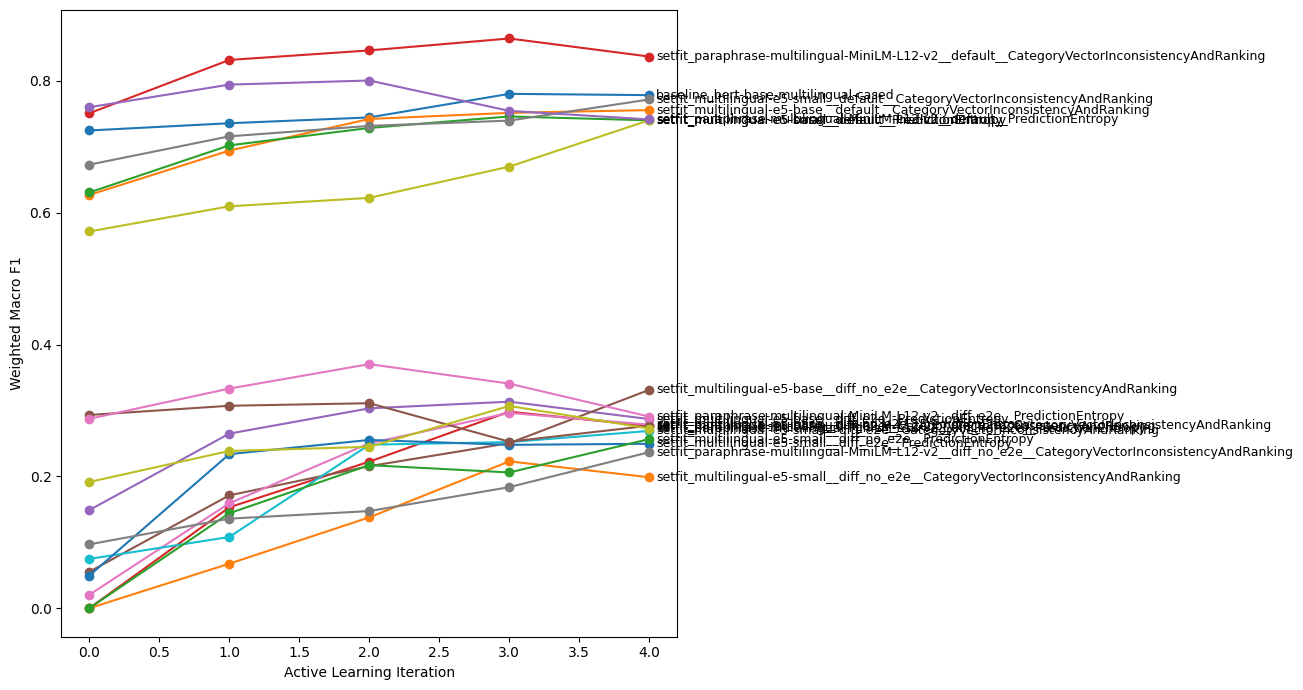

In [3]:
df["iteration"] = df["params.iteration"].astype(int)
df["f1"] = df["metrics.weighted_avg_f1"]
df = df.dropna(subset=["f1"])

df["model_config"] = df["tags.mlflow.runName_y"]

plt.figure(figsize=(13, 7))

for config, g in df.groupby("model_config"):
    g = g.sort_values("iteration")
    plt.plot(g["iteration"], g["f1"], marker="o")
    plt.text(
        g["iteration"].iloc[-1] + 0.05,
        g["f1"].iloc[-1],
        config,
        fontsize=9,
        va="center"
    )

plt.xlabel("Active Learning Iteration")
plt.ylabel("Weighted Macro F1")
plt.tight_layout()
plt.savefig("plot.png")

## Separate plot: Differentiable head vs normal head

In [4]:
AGG_METRIC = "metrics.macro_avg_f1"

# Convert the column to actual boolean
df["params.clf_factory.classification_kwargs.use_differentiable_head"] = \
    df["params.clf_factory.classification_kwargs.use_differentiable_head_y"].map(
        lambda x: True if str(x).lower() == "true" else False
    )

# Then create head_type
df["head_type"] = df[
    "params.clf_factory.classification_kwargs.use_differentiable_head"
].map({True: "Differentiable head", False: "Logit head"})


df["f1"] = df[AGG_METRIC]
df = df.dropna(subset=["f1"])

In [5]:
def shorten_name(full_name):
    # Shorten only the base model (first part before __), keep the rest
    parts = full_name.split("__")
    base = parts[0].replace("setfit_multilingual-", "setfit_ml-").replace("setfit_paraphrase-multilingual", "setfit_paraphrase-ml")
    parts[-1] = parts[-1].replace("PredictionEntropy", "PE").replace("CategoryVectorInconsistencyAndRanking", "CVIAR")
    return "|".join([base] + parts[1:])


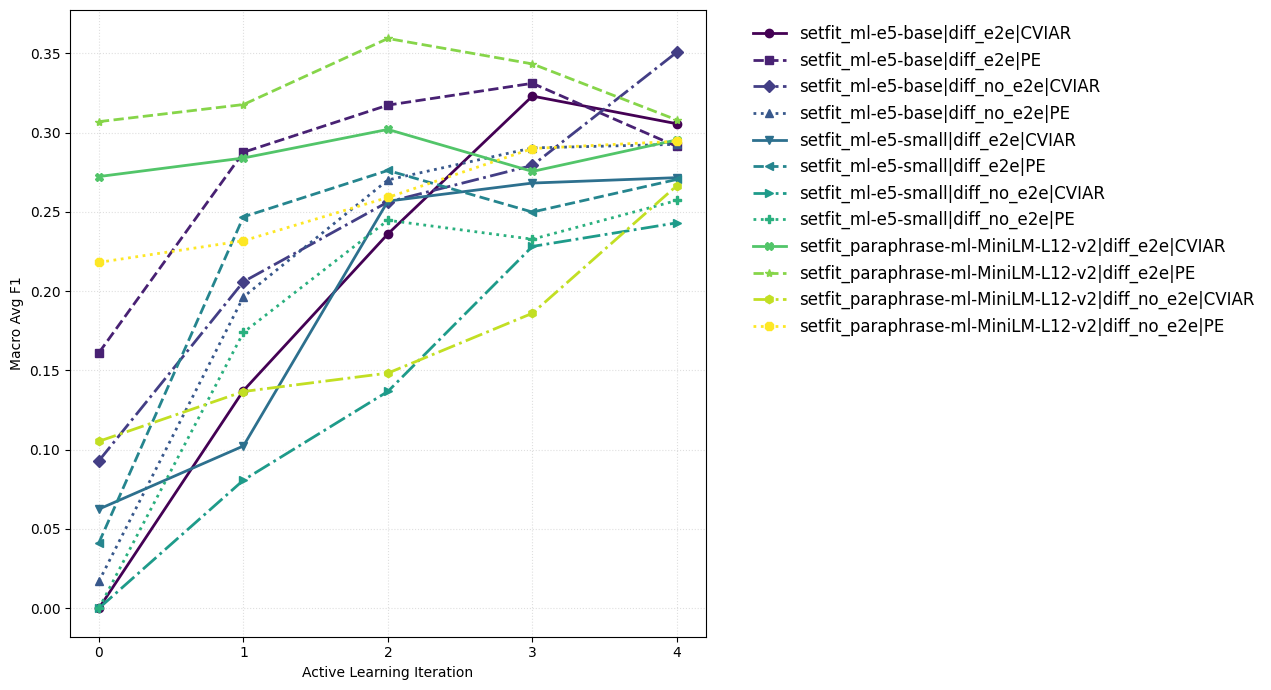

In [14]:
from matplotlib.ticker import MaxNLocator

logit_df = df[df["head_type"] == "Differentiable head"]

plt.figure(figsize=(13, 7))

configs = logit_df["model_config"].unique()
n_configs = len(configs)

# Viridis colormap with evenly spaced colors
colors = plt.cm.viridis(np.linspace(0, 1, n_configs))

line_styles = ["-", "--", "-.", ":"]
markers = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*", "h", "8"]

for i, (config, g) in enumerate(logit_df.groupby("model_config")):
    g = g.sort_values("iteration")

    plt.plot(
        g["iteration"],
        g["f1"],
        color=colors[i],
        linestyle=line_styles[i % len(line_styles)],
        marker=markers[i % len(markers)],
        linewidth=2,
        markersize=6,
        label=shorten_name(config)
    )

plt.xlabel("Active Learning Iteration")
plt.ylabel("Macro Avg F1")
#plt.title("Differentiable Head Models – Macro Avg F1 per Iteration")

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=12,
    frameon=False
)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, linestyle=":", alpha=0.4)
plt.tight_layout()
plt.savefig("diff_head_models_viridis.png", dpi=300)

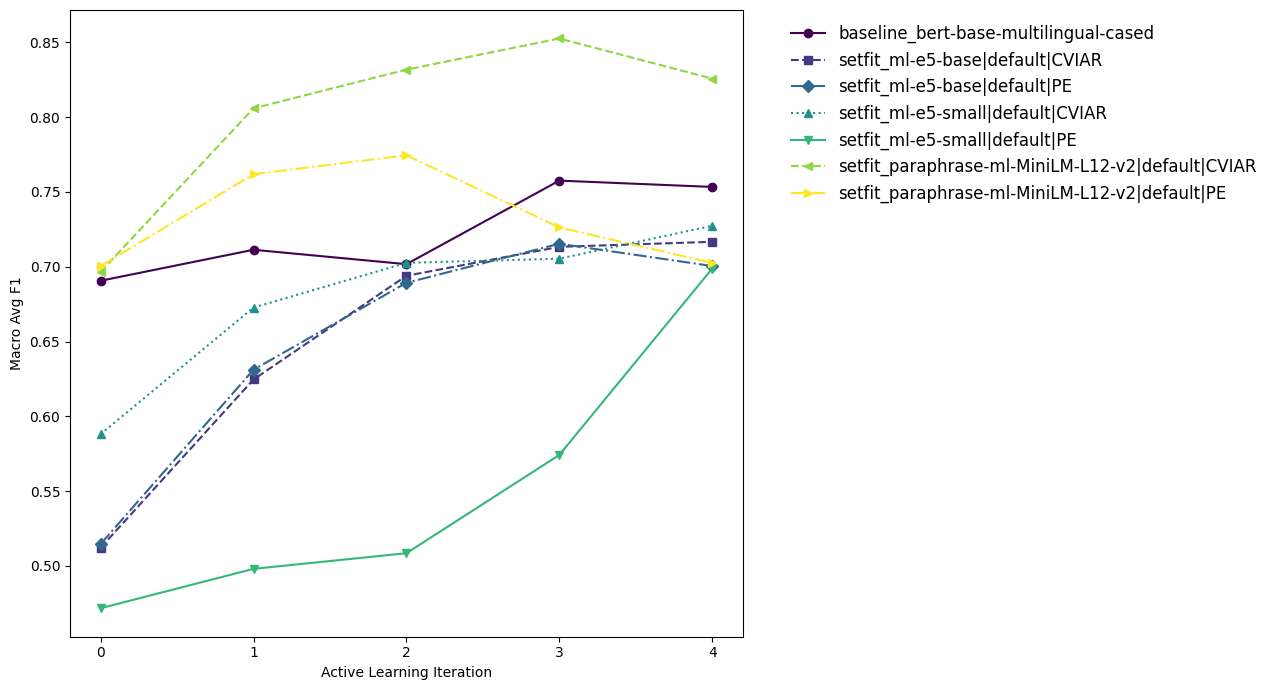

In [15]:
logit_df = df[df["head_type"] != "Differentiable head"]

configs = logit_df["model_config"].unique()
n_configs = len(configs)
colors = plt.cm.viridis(np.linspace(0, 1, n_configs))

plt.figure(figsize=(13, 7))

for i, (config, g) in  enumerate(logit_df.groupby("model_config")):
    g = g.sort_values("iteration")
    plt.plot(
        g["iteration"],
        g["f1"],
        color=colors[i],
        linestyle=line_styles[i % len(line_styles)],
        marker=markers[i % len(markers)],
        label=shorten_name(config)
    )

plt.xlabel("Active Learning Iteration")
plt.ylabel("Macro Avg F1")
#plt.title("Logit Head Models – Macro Avg F1 per Iteration")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12, frameon=False)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.savefig("logit_head_models.png")

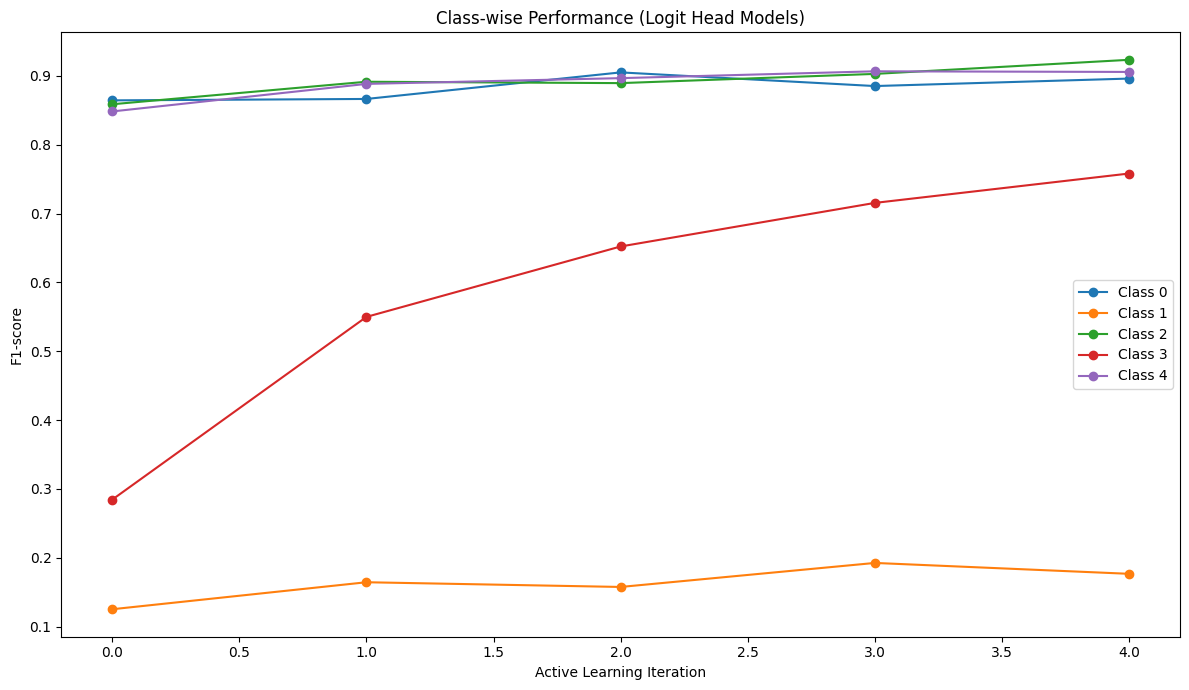

In [19]:
logit_df = df[df["head_type"] != "Differentiable head"]

class_f1_cols = [
    c for c in logit_df.columns
    if c.startswith("metrics.") and c.split(".")[1].split("_")[0].isdigit() and c.endswith("_f1-score")
]

class_f1_cols = sorted(class_f1_cols, key=lambda x: int(x.split(".")[1].split("_")[0]))

plt.figure(figsize=(12, 7))

for col in class_f1_cols:
    class_id = col.split(".")[1].split("_")[0]
    mean_curve = (
        logit_df.groupby("iteration")[col]
        .mean()
        .sort_index()
    )
    plt.plot(mean_curve.index, mean_curve.values, marker="o", label=f"Class {class_id}")

plt.xlabel("Active Learning Iteration")
plt.ylabel("F1-score")
plt.title("Class-wise Performance (Logit Head Models)")
plt.legend()
plt.tight_layout()
plt.savefig("logit_classwise_f1.png")

In [11]:
codes_health = ["physical_health", "mental_health", "daily_functioning", "health_unspecific", "health_none"]
codes_freq = ["freq_mentioned", "freq_not_mentioned"]
codes_neg = ["health_none", "freq_not_mentioned"]

codes_combined = codes_health + codes_freq
code_full = {label: idx for idx, label in enumerate(codes_combined)}
code_pos = {k: v for k, v in code_full.items() if k not in codes_neg}
code_neg = {k: v for k, v in code_full.items() if k in codes_neg}
code_pos_new = {k: i for k, i in enumerate(code_pos.keys())}

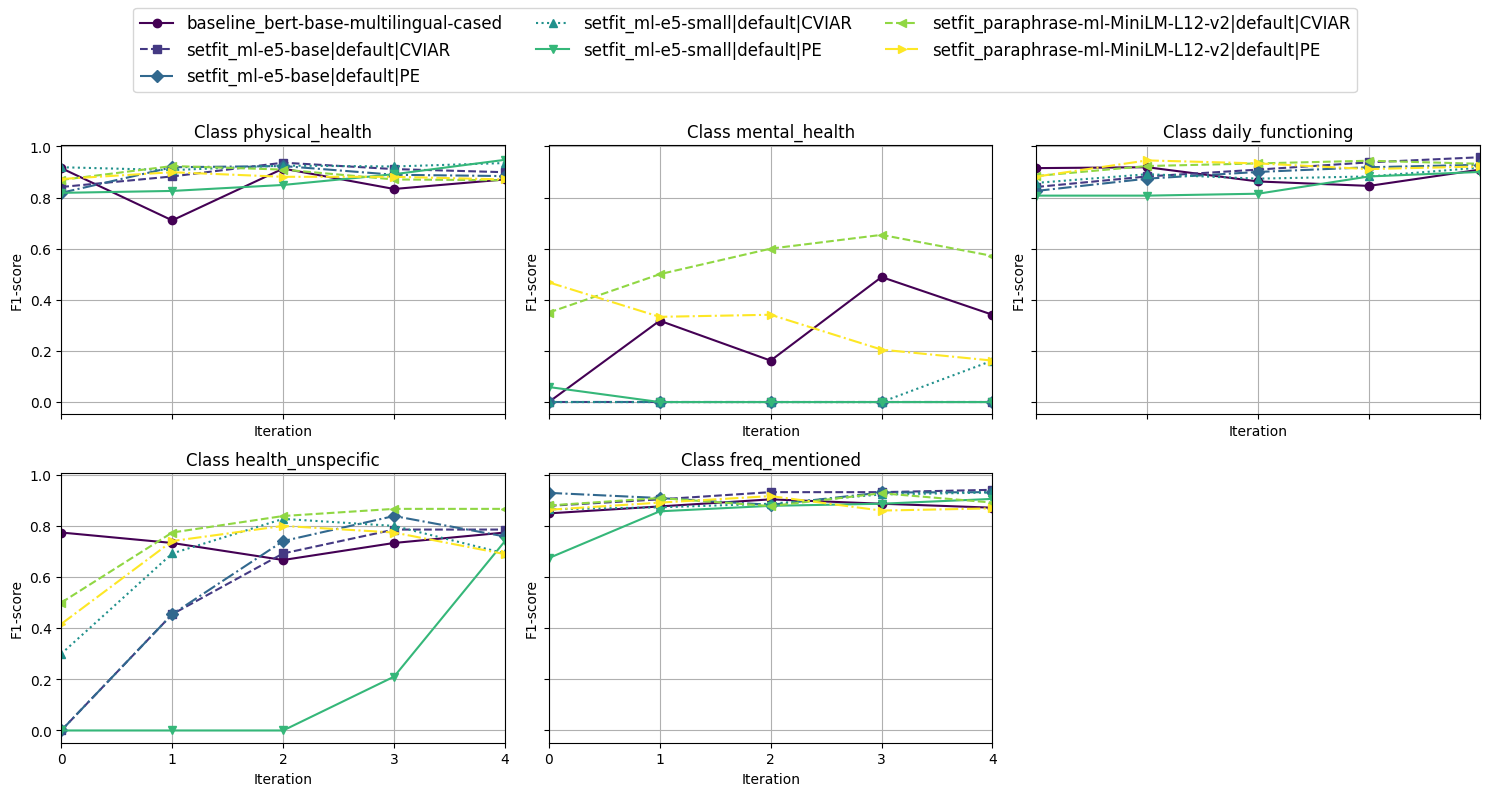

In [33]:
import math

# number of classes
num_classes = len(class_f1_cols)
configs = logit_df["model_config"].unique()
n_configs = len(configs)
colors = plt.cm.viridis(np.linspace(0, 1, n_configs))

xmin = logit_df["iteration"].min()
xmax = logit_df["iteration"].max()

# Grid layout (adjust to your taste)
cols = 3
rows = math.ceil(num_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), sharex=True, sharey=True)
axes = axes.flatten()  # flatten in case grid is not square

for i, col in enumerate(class_f1_cols):
    ax = axes[i]
    class_id = int(col.split(".")[1].split("_")[0])
    
    for j, (model_name, g) in enumerate(logit_df.groupby("model_config")):
        g = g.sort_values("iteration")
        ax.plot(
            g["iteration"],
            g[col],
            linestyle=line_styles[j % len(line_styles)],
            marker=markers[j % len(markers)],
            color=colors[j],
            label=shorten_name(model_name)
        )
    ax.set_title(f"Class {code_pos_new.get(class_id)}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("F1-score")
    ax.grid(True)

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Force integer x-axis
for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.subplots_adjust(top=0.82)

# Shared legend outside the grid
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=12)

plt.savefig("logit_classwise_f1_grid.png")

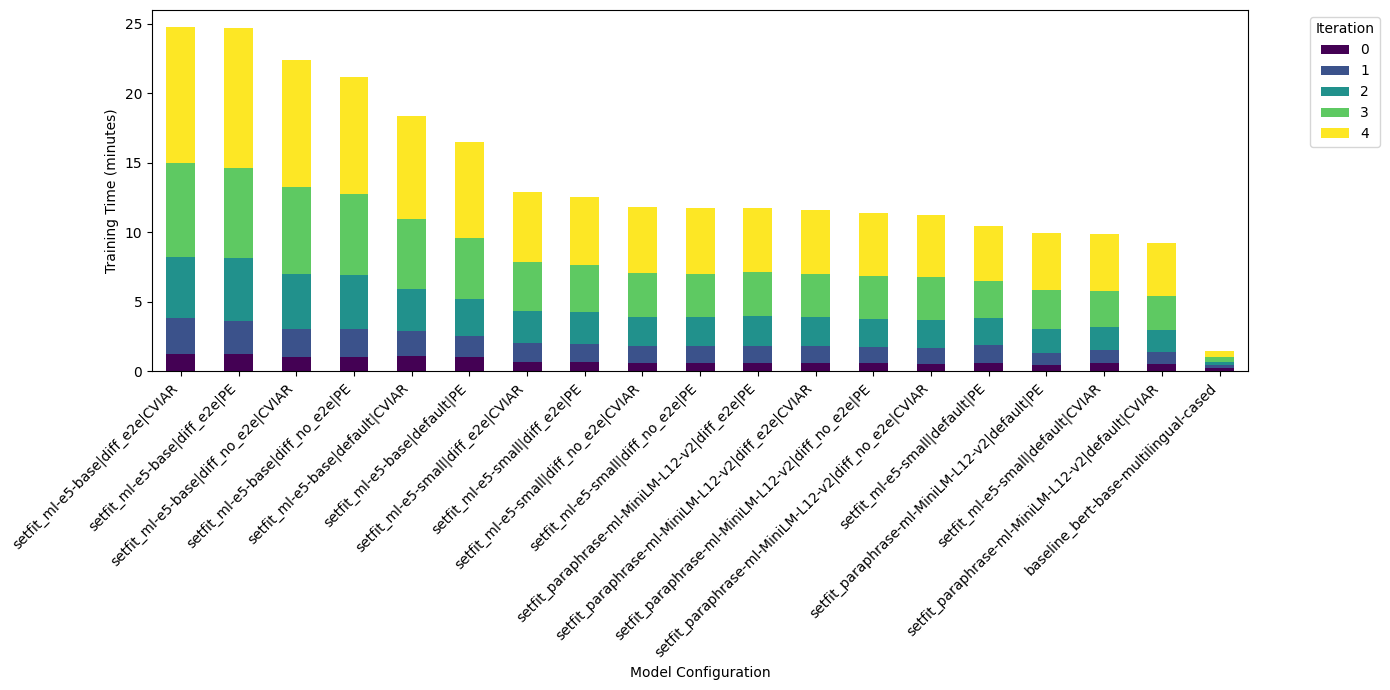

In [13]:
TRAIN_TIME_COL = "params.training_duration"

df[TRAIN_TIME_COL] = pd.to_numeric(df[TRAIN_TIME_COL], errors='coerce')
df = df.dropna(subset=[TRAIN_TIME_COL])

time_df = df.groupby(["model_config", "iteration"])[TRAIN_TIME_COL].sum().reset_index()

pivot_time = time_df.pivot(
    index="model_config",
    columns="iteration",
    values=TRAIN_TIME_COL
).fillna(0)

pivot_time["total_time"] = pivot_time.sum(axis=1)
pivot_time = pivot_time.sort_values("total_time", ascending=False)

pivot_time.index = [shorten_name(idx) for idx in pivot_time.index]

plot_df = pivot_time.drop(columns="total_time") / 60  # convert to minutes

plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    colormap="viridis"
)

plt.ylabel("Training Time (minutes)")
plt.xlabel("Model Configuration")
#plt.title("Training Duration per Model (Stacked by Iteration)")
plt.legend(title="Iteration", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("training_time_stacked_sorted_minutes.png")